## Anomaly Detection via IsolationForest

Mike Ames  
mikames@amazon.com  
01APR2022  


### Overview
-----

There are dozens (probably hundreds) of books dedicated to the subject of anomaly and outlier detection. The most common approaches expect that you know what “normal” looks like so that you can identify instances that don’t conform to the “normal” profile. There are statistical techniques, supervised, unsupervised, even semi-supervised methods to look at anomalies in data. This notebook uses the Isolation Forest method to detect anomalous data points within a data set. Isolation Forest is a powerful unsupervised algorithm which can be used to identify non-obvious observations which diverge from otherwise well-structured data. 

Isolation Forest associates each data point with anomaly score. The lower, the more abnormal the observation is. The definitions of "low" and "high" depend on the dataset as well see.


### How to use this notebook 
-----
The goal of this notebook is to identify and label a sufficent anomalies so that we can train a Amazon Fraud Detector model. To do this we are going to perform the following

1. profile the dataset and identify numeric and categorical variables
2. train and evaluate an Isolation Forest 
3. select an anomaly score threshold which will be used to create an EVENT_LABEL 
4. score the dataset to produce a new EVENT_LABEL
5. write the updated dataset to a new CSV file. 


#### Setup 
-----
To get started you need the following:
1. a python enviornment i sugest simply downloading and installing anaconda https://www.anaconda.com/ this will install all of the required packages and provide a jupyter notebook enviornment. 
2. location of your CSV dataset. 
3. make a copy of this notebook and run it with the sampel dataset provided
4. update your version of the notebook with your CSV file
5. walk through the notebook and update the anomaly_score_threshold 
6. it will produce a new CSV file which you can then dump in S3 and train an Fraud Detector Model with. 



<div class="alert alert-info"> <strong> Overview </strong>

- INPUT_FILE - the path and file name of the CSV file for processing 
- OUTPUT_FILE - the path and name of the CSV file produced from running the notebook. 

</div>


In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.ensemble import IsolationForest           #- isolation forest 

# -- we need these to make our pipelines 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

# -- need this to render charts in notebook -- 
%matplotlib inline

## Your Dataset and Location 

---- 

My sample dataset happens to be located in a github repository, yours could be local or on a file system somewhere just change the read_csv to the appropraite location. All we are going to do here is read the file into a panda's dataframe. Then 

<div class="alert alert-info"> <strong> Define INPUT and OUTPUT FILES </strong>
 
- INPUT_FILE : fully qualified path to the input CSV file  
- OUTPUT_FILE : fully qualified path to the output CSV file   

</div>

### Dataset Format 

Assuming we are planning on using Amazon Fraud Detector, your file may or maynot contain an EVENT_LABEL but should contain an EVENT_TIMESTAMP. We will be creating an EVENT_LABEL based on the IsolationForest score below. 

In [2]:

# -- set to your file location -- 
INPUT_FILE = "https://raw.githubusercontent.com/mikames/IsolationForestExample/main/data/rcf_110k.csv"
OUTPUT_FILE = "fraud_detector_file_{}.csv".format(datetime.now().strftime("%Y_%m_%d"))
print("Input File : {}".format(INPUT_FILE))
print("Output File: {}".format(OUTPUT_FILE))

# -- read file into a dataframe called "df" 
df = pd.read_csv(INPUT_FILE)
df.head()

Input File : https://raw.githubusercontent.com/mikames/IsolationForestExample/main/data/rcf_110k.csv
Output File: fraud_detector_file_2022_04_21.csv


,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency,EVENT_TIMESTAMP,ip_address,email_address,EVENT_LABEL
0,11.0,38334.0,36466.0,eur,2021-08-14 05:38:58,57.115.15.248,lcarlson@example.org,legit
1,6.0,50104.0,24775.0,usd,2021-10-21 13:29:39,203.218.41.214,brianfowler@example.org,legit
2,16.0,21516.0,46364.0,usd,2021-06-18 03:28:47,131.7.35.71,lthomas@example.org,legit
3,6.0,50446.0,23668.0,usd,2021-05-08 22:44:29,150.245.11.96,victoria20@example.com,legit
4,10.0,43560.0,32309.0,eur,2021-08-24 00:17:08,155.110.112.38,amandamartinez@example.com,legit


## Profile the data. 
-----

The following function simply profiles your data frame and determines which variables shoudl be included/excluded from the ilsoation forest.


In [3]:
def df_profile(df):
    
    df = df.copy()
    
    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    
    categorical_features = [ c for c in df.select_dtypes(include = np.object).columns ]
   
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2 
    df_stats['feature_type'] = "IGNORE"
    df_stats.loc[(df_stats["dtype"] == object) & (df_stats["nunique"] <= 32), 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    
    # -- part 3 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    #if null_pct > 0.2 then feature_warning = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    #df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL",'feature_warning' ] = "TARGET VARIABLE"
    return df_stats

df_stats = df_profile(df)
df_stats

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,account_tenure_yrs,float64,110000,25,11.412009,0.0,24.0,0,110000,0.0,0.000227,NUMERIC,NO WARNING
1,normalized_currency_amt,float64,110000,35468,41020.239745,100.0,99999.0,0,110000,0.0,0.322436,NUMERIC,NO WARNING
2,original_currency_amt,float64,110000,49692,42961.098964,100.0,99999.0,0,110000,0.0,0.451745,NUMERIC,NO WARNING
3,currency,object,110000,3,NaN,cad,usd,0,110000,0.0,0.000027,CATEGORY,NO WARNING
4,EVENT_TIMESTAMP,object,110000,109800,NaN,2021-04-13 03:45:59,2022-04-13 09:28:40,0,110000,0.0,0.998182,EVENT_TIMESTAMP,"EXCLUDE, GT 70% UNIQUE"
5,ip_address,object,110000,109999,NaN,1.1.25.108,99.94.90.205,0,110000,0.0,0.999991,IGNORE,"EXCLUDE, GT 70% UNIQUE"
6,email_address,object,110000,93435,NaN,aabbott@example.com,zzimmerman@example.com,0,110000,0.0,0.849409,IGNORE,"EXCLUDE, GT 70% UNIQUE"
7,EVENT_LABEL,object,110000,2,NaN,fraud,legit,0,110000,0.0,0.000018,TARGET,TARGET VARIABLE


## Data Transformation 
-----
IsolationForests only work with numeric data so we are going to identify which variables we want to use based on the profile and how we'll handle nulls and categorical variables. 

- numeric variables with null values will be replaced with -1 
- categorical variables with null values will be replaced with "UNKNOWN"
- categorical variables will be dummy encoded for simplicy

>Note: only categories with fewer than 32 levels are included, there are of course several other transformations we could perform but this will get the ball rolling!

----
If you want to include or exclude varaibles in the detection simply specify the variable names in a list like this 

```python

numeric_features = ['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt']
categorical_features = ['currency']

```

In [4]:
numeric_features = df_stats[df_stats["feature_type"] == "NUMERIC"]["feature_name"].tolist()
numeric_features

['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt']

In [5]:
categorical_features = df_stats[df_stats["feature_type"] == "CATEGORY"]["feature_name"].tolist()
categorical_features

['currency']

In [6]:
# combined feature names of numeric and categorical 
feature_names = numeric_features + categorical_features

In [7]:


CONTAMINATION_RATE = 0.001 # -- what is the expected anomaly rate 1 in a 1k or 1 in 10k ? 

# -- define pipeline --
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('countenc',  OneHotEncoder())  
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value=-1 ))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

model_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', IsolationForest(
        n_estimators = 100,
        max_samples  = 0.1,
        n_jobs=-1,
        contamination = CONTAMINATION_RATE
    ))
])


model_pipeline.fit(df[numeric_features + categorical_features])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('countenc',
                                                                   OneHotEncoder())]),
                                                  ['currency']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['account

## Evaluate 

-----

So here we are going to score the dataset and evaluate a "suggested" outlier score threshold. this will ultimately be used to create our new "EVENT_LABEL" 

1. First look at the number of outliers created, if there are too many adjust the CONTAMINATION_RATE above and retrain.  
2. Next look at the score distribution and the "sugested outlier_score threshold" this will be used to create your EVENT_LABEL
3. Finally we'll look at the number of "anomalies" produced at the "sugested outlier_score threshold", you can simply increase or decrease the threshold to generate the number of anomalies.  


In [8]:
# -- 1. score the dataset and look at "raw number" of anomalies created if large set a smaller contamination rate -- 
df["outlier_ind"] = model_pipeline.predict(df[numeric_features + categorical_features])
df["outlier_score"] = model_pipeline.score_samples(df[numeric_features + categorical_features])
df["outlier_ind"].value_counts()

 1    109890
-1       110
Name: outlier_ind, dtype: int64

In [9]:
# -- 2. sugested score threshold 
sugested_threshold = df.sort_values("outlier_score").iloc[400]["outlier_score"]
print("sugested outlier_score threshold {:.3f}".format(sugested_threshold))

outlier_count = df.query('outlier_score <= @sugested_threshold').shape[0]
print("number of anomalies produced at that score threshold: {:.0f}".format(outlier_count))

sugested outlier_score threshold -0.668
number of anomalies produced at that score threshold: 401


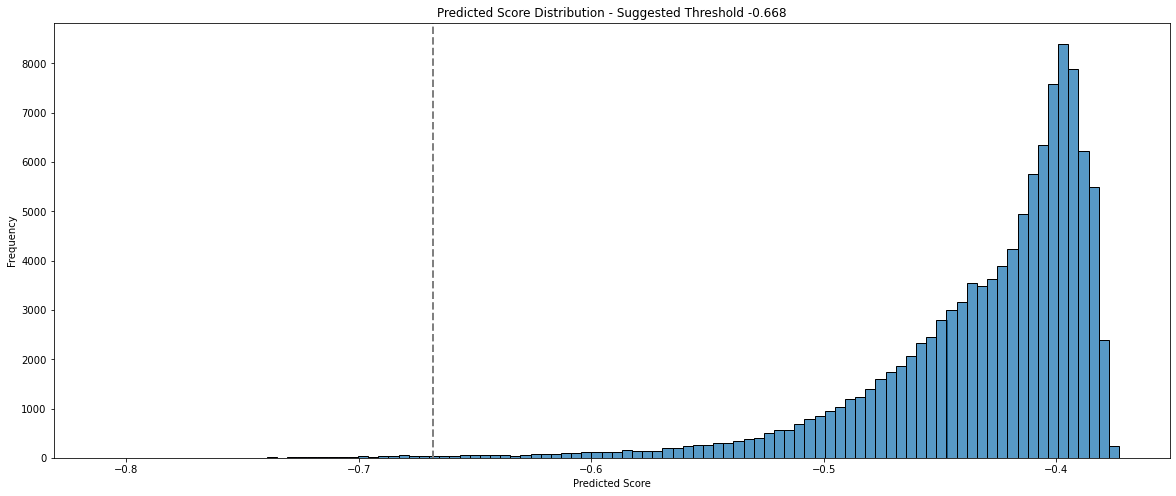

In [10]:
# -- plot score distribution -- 
plt.figure(figsize = (20,8))
sns.histplot(data=df,x="outlier_score", bins=100)
plt.title("Predicted Score Distribution - Suggested Threshold {:.3f}".format(sugested_threshold))
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.axvline(x=sugested_threshold, ls='--', linewidth = 2, c='grey')

## Create EVENT_LABEL and write out Dataset 

------

Here we are going to actually create our EVENT_LABEL variable, you can replace the value of "anomaly" and "legit" with what every lables you want to use in fraud detector. 

1. do a quick check on the value counts of legit and anomaly
2. drop the outlier_score, outlier_ind columns - these are no longer needed and will give AFD greif. 
3. write the "scored" CSV out, it's now ready for import into AFD. 




In [11]:
# 1. double check the value counts for anomaly and legit look right 
df["EVENT_LABEL"] = np.where(df["outlier_score"] <= sugested_threshold, "anomaly","legit")
df["EVENT_LABEL"].value_counts()

legit      109599
anomaly       401
Name: EVENT_LABEL, dtype: int64

In [12]:
# 2. drop 'outlier_score' and 'outlier_ind' from the dataset! 
df = df.drop(['outlier_score', 'outlier_ind'], axis=1).copy()
df.head()

,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency,EVENT_TIMESTAMP,ip_address,email_address,EVENT_LABEL
0,11.0,38334.0,36466.0,eur,2021-08-14 05:38:58,57.115.15.248,lcarlson@example.org,legit
1,6.0,50104.0,24775.0,usd,2021-10-21 13:29:39,203.218.41.214,brianfowler@example.org,legit
2,16.0,21516.0,46364.0,usd,2021-06-18 03:28:47,131.7.35.71,lthomas@example.org,legit
3,6.0,50446.0,23668.0,usd,2021-05-08 22:44:29,150.245.11.96,victoria20@example.com,legit
4,10.0,43560.0,32309.0,eur,2021-08-24 00:17:08,155.110.112.38,amandamartinez@example.com,legit


In [13]:
# 3. write new output CSV file out. 
df.to_csv(OUTPUT_FILE,index=False)
print("file written to: {}".format(OUTPUT_FILE))

file written to: fraud_detector_file_2022_04_21.csv
